<a href="https://colab.research.google.com/github/jejjohnson/gp_model_zoo/blob/master/code/numpyro/numpyro_gpr_mle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sparse Gaussian Process w/ Numpyro

My starting notebook where I install all of the necessary libraries and load some easy 1D/2D Regression data to play around with.

In [ ]:
#@title Install Packages
%%capture
!pip install jax jaxlib chex optax loguru
!pip install "git+https://github.com/pyro-ppl/numpyro.git#egg=numpyro"
!pip uninstall tensorflow -y -q
!pip install -Uq tfp-nightly[jax] > /dev/null

In [ ]:
#@title Load Packages
# TYPE HINTS
from typing import Tuple, Optional, Dict, Callable, Union

# JAX SETTINGS
import jax
import jax.numpy as jnp
import jax.random as random


# JAX UTILITY LIBRARIES
import chex

# NUMPYRO SETTINGS
import numpyro
import numpyro.distributions as dist
from numpyro.infer.autoguide import AutoDiagonalNormal
from numpyro.infer import SVI, Trace_ELBO

# NUMPY SETTINGS
import numpy as np
np.set_printoptions(precision=3, suppress=True)

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)

# PANDAS SETTINGS
import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

# LOGGING SETTINGS
import loguru

%load_ext autoreload
%autoreload 2

In [ ]:
seed = 123
key = jax.random.PRNGKey(seed=seed)

N = 50
noise = 0.2

x = jax.random.uniform(key=key, minval=-3.0, maxval=3.0, shape=(N,)).sort().reshape(-1, 1)
f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
signal = f(x)
y = signal + jax.random.normal(key, shape=signal.shape) * noise
xtest = jnp.linspace(-3.1, 3.1).reshape(-1, 1)
ytest = f(xtest)

# x = jax.random.uniform(key=key, minval=0.0, maxval=5.0, shape=(N,)).sort().reshape(-1, 1)
# f = lambda x: 0.5 * jnp.sin(3.0 * x)
# signal = f(x)
# y = signal + noise * jax.random.normal(key, shape=signal.shape)

# xtest = jnp.linspace(-1.0, 6.0).reshape(-1, 1)
# ytest = f(xtest)

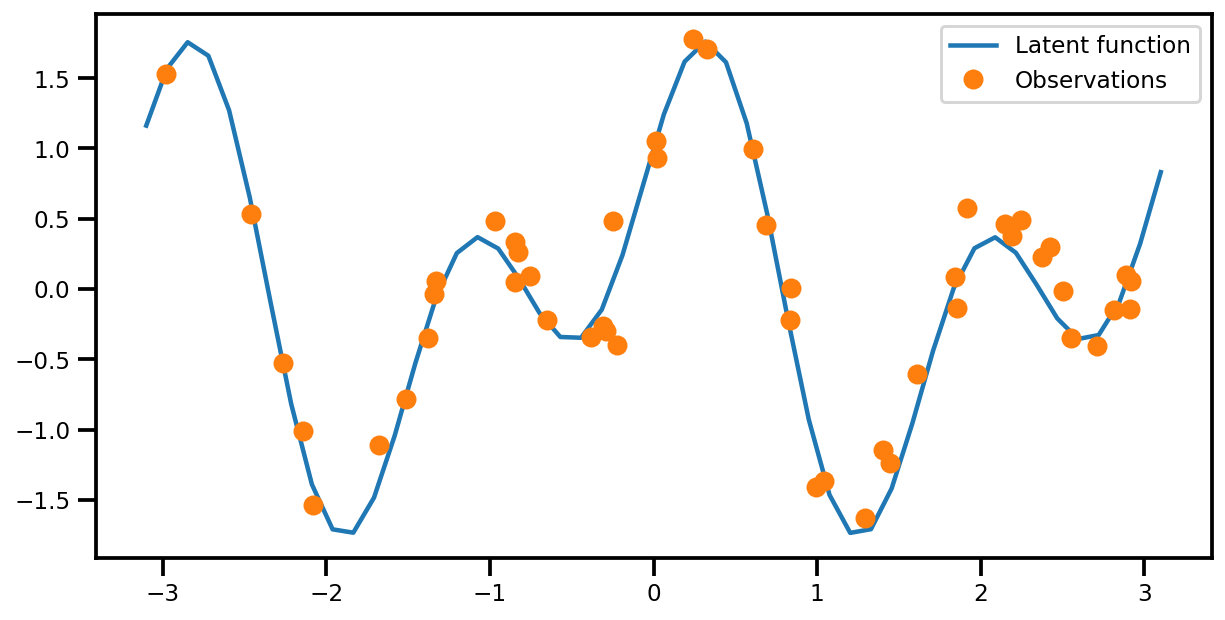

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(xtest, ytest, label="Latent function", color="tab:blue")
ax.plot(x, y, "o", label="Observations", color="tab:orange")
ax.legend(loc="best")
plt.show()

## Gaussian Process Model

In [ ]:



# squared euclidean distance
def sqeuclidean_distance(x: np.array, y: np.array) -> float:
    return jnp.sum((x - y) ** 2)

# distance matrix
def cross_covariance(func: Callable, x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """distance matrix"""
    return jax.vmap(lambda x1: jax.vmap(lambda y1: func(x1, y1))(y))(x)

# kernel function
def rbf_kernel(X, Y, variance, length_scale):
    # distance formula
    deltaXsq = cross_covariance(
        sqeuclidean_distance, 
        X / length_scale, 
        Y / length_scale
    )

    # rbf function
    K = variance * jnp.exp(-0.5 * deltaXsq)
    return K

def GP(X, y):
    # Set informative log-normal priors on kernel hyperparameters.
    # η = pm.HalfCauchy("η", beta=5)
    # η = numpyro.sample("variance", dist.HalfCauchy(scale=5.))
    # ℓ = numpyro.sample("length_scale", dist.Gamma(2., 1.))
    # σ = numpyro.sample("noise", dist.HalfCauchy(scale=5.))

    η = numpyro.param("kernel_var", init_value=1.0, constraints=dist.constraints.positive)
    ℓ = numpyro.param("kernel_length", init_value=0.1,  constraints=dist.constraints.positive)
    σ = numpyro.param("sigma", init_value=0.01, onstraints=dist.constraints.positive)

    # Compute kernel
    K = rbf_kernel(X, X, η, ℓ)
    K += jnp.eye(X.shape[0]) * jnp.power(σ, 2)

    Lff = jnp.linalg.cholesky(K)

    # Sample y according to the standard gaussian process formula
    return numpyro.sample("y", dist.MultivariateNormal(
        loc=jnp.zeros(X.shape[0]),
        scale_tril=Lff
        )
        .expand_by(y.shape[:-1]).to_event(y.ndim - 1)
        , 
        obs=y
    )


def empty_guide(X, y):
    pass

In [ ]:
K = rbf_kernel(x, x, 1.0, 1.0)

# check shape
chex.assert_shape(K, (x.shape[0], x.shape[0]))

## Exact GP - Maximum Marginal Likelihood

In [ ]:
from numpyro.infer.autoguide import AutoDelta#AutoDiagonalNormal, AutoIAFNormal, AutoLaplaceApproximation, AutoMultivariateNormal

In [ ]:
type(x), type(y), y.shape

(jax.interpreters.xla._DeviceArray, jax.interpreters.xla._DeviceArray, (50, 1))

In [ ]:
with numpyro.handlers.seed(rng_seed=123):
    t = GP(x, y)


In [ ]:
print(t.shape)

(50, 1)


In [ ]:
# reproducibility
rng_key = random.PRNGKey(0)

gp_model = GP

# Setup
# guide = numpyro.infer.autoguide.AutoDelta(GP)
optimizer = numpyro.optim.Adam(step_size=0.01)
# optimizer = numpyro.optim.Minimize()
# optimizer = optax.adamw(learning_rate=0.1)
svi = SVI(gp_model, empty_guide, optimizer, loss=Trace_ELBO())
svi_results = svi.run(random.PRNGKey(1), 1_000, x, y.T)

100%|██████████| 1000/1000 [00:02<00:00, 412.30it/s, init loss: 822.0859, avg. loss [951-1000]: 18.4708]


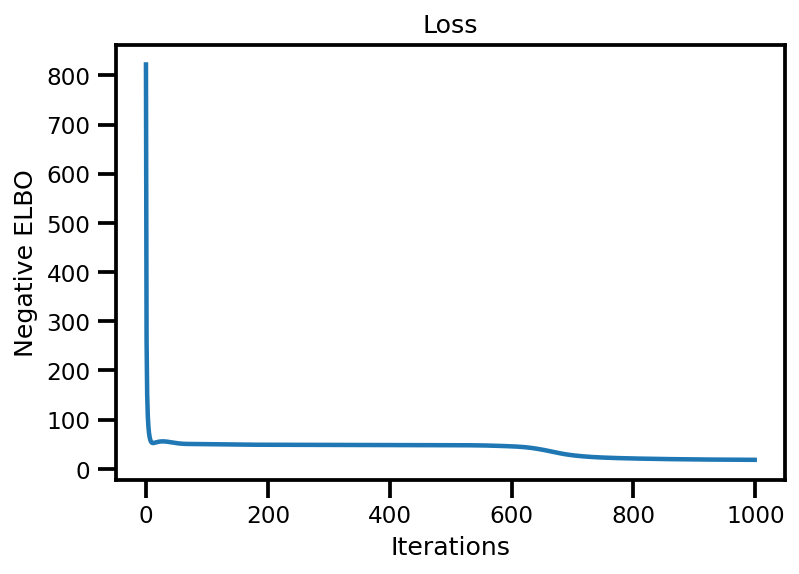

In [ ]:
fig, ax = plt.subplots()

ax.plot(svi_results.losses);
ax.set(
    title = "Loss",
    xlabel="Iterations",
    ylabel="Negative ELBO"
    );
plt.show()

### Extracting the Params

In [ ]:
from pprint import pprint
# Take them directly
learned_params = svi_results.params
pprint(learned_params)

{'kernel_length': DeviceArray(0.39, dtype=float32),
 'kernel_var': DeviceArray(0.842, dtype=float32),
 'sigma': DeviceArray(0.19, dtype=float32)}


### Predictions

In [ ]:
def cholesky_factorization(K: np.ndarray, Y: np.ndarray) -> Tuple[np.ndarray, bool]:
    """Cholesky Factorization"""
    # cho factor the cholesky
    L = jax.scipy.linalg.cho_factor(K, lower=True)

    # weights
    weights = jax.scipy.linalg.cho_solve(L, Y)

    return L, weights

# Predictive Mean and Variance
def predict(X, Y, X_test, variance, length_scale, noise):

    K = rbf_kernel(X, X, variance, length_scale)
    L, alpha = cholesky_factorization(K + noise * np.eye(K.shape[0]), Y)

    # Calculate the Mean
    K_x = rbf_kernel(X_test, X, variance, length_scale)
    mu_y = np.dot(K_x, alpha)

    # Calculate the variance
    v = jax.scipy.linalg.cho_solve(L, K_x.T)

    # Calculate kernel matrix for inputs
    K_xx = rbf_kernel(X_test, X_test, variance, length_scale)

    cov_y = K_xx - jnp.dot(K_x, v)
    return mu_y, cov_y


# Summarize function posterior.
def posterior(rng_key, X, Y, X_test, variance, length_scale, noise):
    m, cov = predict(X, Y, X_test, variance, length_scale, noise)

    return random.multivariate_normal(rng_key, mean=m, cov=cov)

def summarize_posterior(preds, ci=96):
    ci_lower = (100 - ci) / 2
    ci_upper = (100 + ci) / 2
    preds_mean = preds.mean(0)
    preds_lower = jnp.percentile(preds, ci_lower, axis=0)
    preds_upper = jnp.percentile(preds, ci_upper, axis=0)
    return preds_mean, preds_lower, preds_upper

In [ ]:
y_pred, y_cov = predict(
    x, y.squeeze(), xtest, 
    variance=learned_params['kernel_var'], 
    length_scale=learned_params['kernel_length'], 
    noise=learned_params['sigma']
)

y_var = jnp.diagonal(y_cov)
y_std = jnp.sqrt(y_var)

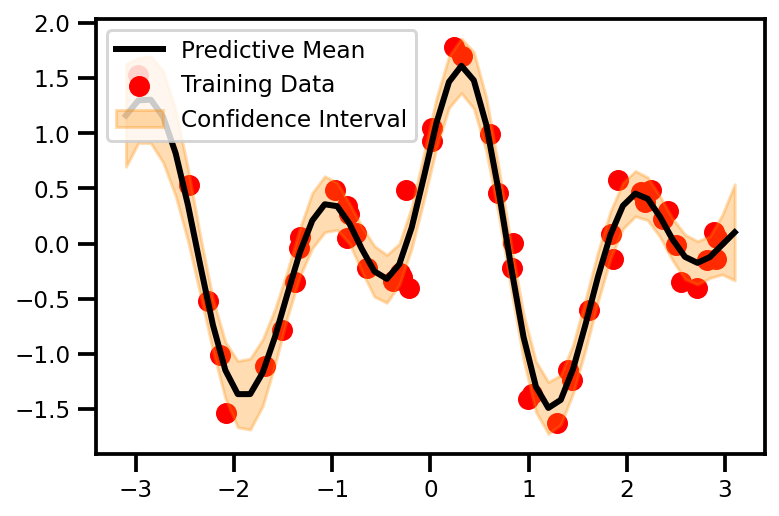

In [ ]:
fig, ax = plt.subplots(ncols=1, figsize=(6, 4))

ax.scatter(x, y, label='Training Data', color='red')
ax.plot(xtest, y_pred, label='Predictive Mean', color='black', linewidth=3)
ax.fill_between(
    xtest.squeeze(),
    y_pred - y_std,
    y_pred + y_std,
    label='Confidence Interval',
    alpha=0.3,
    color='darkorange'
    )
ax.legend()